In [1]:
import config as c
import numpy as np

# Date wrangling
from datetime import datetime, timedelta

# Data wrangling
import pandas as pd 

from functions.timeseries import data_pre_processing

# The deep learning class
from functions.deep_model import DeepModelTS

# Reading the configuration file
import yaml

# Directory managment 
import os

# Ploting packages
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Seaborn for beautiful graphs
import seaborn as sns
# sns.set(context='paper', style='whitegrid', palette='deep', font='sans-serif', font_scale=1.5, color_codes=True, rc=None)

# Date formatting
from matplotlib.dates import DateFormatter

# Statistics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt

# Deep learning: 
from keras.models import Sequential
from keras.layers import LSTM, Dense, SimpleRNN

In [2]:
# DEEP MODEL CLASS

class DeepModelTS():
    """
    A class to create a deep time series model
    """
    def __init__(
        self, 
        data: pd.DataFrame, 
        Y_var: str,
        lag: int,
        LSTM_layer_depth: int, 
        epochs=10, 
        batch_size=256,
        train_test_split=0
    ):

        self.data = data 
        self.Y_var = Y_var 
        self.lag = lag 
        self.LSTM_layer_depth = LSTM_layer_depth
        self.batch_size = batch_size
        self.epochs = epochs
        self.train_test_split = train_test_split

    @staticmethod
    def create_X_Y(ts: list, lag: int) -> tuple:
        """
        A method to create X and Y matrix from a time series list for the training of 
        deep learning models 
        """
        X, Y = [], []

        if len(ts) - lag <= 0:
            X.append(ts)
        else:
            for i in range(len(ts) - lag):
                Y.append(ts[i + lag])
                X.append(ts[i:(i + lag)])

        X, Y = np.array(X), np.array(Y)

        # Reshaping the X array to an LSTM input shape 
        X = np.reshape(X, (X.shape[0], X.shape[1], 1))

        return X, Y         

    def create_data_for_NN(
        self,
        use_last_n=None
        ):
        """
        A method to create data for the neural network model
        """
        # Extracting the main variable we want to model/forecast
        y = self.data[self.Y_var].tolist()

        # Subseting the time series if needed
        if use_last_n is not None:
            y = y[-use_last_n:]

        # The X matrix will hold the lags of Y 
        X, Y = self.create_X_Y(y, self.lag)

        # Creating training and test sets 
        X_train = X
        X_test = []

        Y_train = Y
        Y_test = []

        if self.train_test_split > 0:
            index = round(len(X) * self.train_test_split)
            X_train = X[:(len(X) - index)]
            X_test = X[-index:]     
            
            Y_train = Y[:(len(X) - index)]
            Y_test = Y[-index:]

        return X_train, X_test, Y_train, Y_test

    def LSTModel(self):
        """
        A method to fit the LSTM model 
        """
        # Getting the data 
        X_train, X_test, Y_train, Y_test = self.create_data_for_NN()

        # Defining the model
        model = Sequential()
        model.add(LSTM(self.LSTM_layer_depth, activation='relu', input_shape=(self.lag, 1)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse', metrics=['acc'])

        # Defining the model parameter dict 
        keras_dict = {
            'x': X_train,
            'y': Y_train,
            'batch_size': self.batch_size,
            'epochs': self.epochs,
            'shuffle': False
        }

        if self.train_test_split > 0:
            keras_dict.update({
                'validation_data': (X_test, Y_test)
            })

        # Fitting the model 
        model.fit(
            **keras_dict
        )

        # Saving the model to the class 
        self.model = model

        return model

    def predict(self) -> list:
        """
        A method to predict using the test data used in creating the class
        """
        yhat = []

        if(self.train_test_split > 0):
        
            # Getting the last n time series 
            _, X_test, _, _ = self.create_data_for_NN()        

            # Making the prediction list 
            yhat = [y[0] for y in self.model.predict(X_test)]

        return yhat

    def predict_n_ahead(self, n_ahead: int):
        """
        A method to predict n time steps ahead
        """    
        X, _, _, _ = self.create_data_for_NN(use_last_n=self.lag)        

        # Making the prediction list 
        yhat = []

        for _ in range(n_ahead):
            # Making the prediction
            fc = self.model.predict(X)
            yhat.append(fc)

            # Creating a new input matrix for forecasting
            X = np.append(X, fc)

            # Ommiting the first variable
            X = np.delete(X, 0)

            # Reshaping for the next iteration
            X = np.reshape(X, (1, len(X), 1))

        return yhat    


In [3]:
# Reading the hyper parameters for the pipeline
with open(f"{c.loc_par}/conf.yml") as file:
    conf = yaml.load(file, Loader=yaml.FullLoader)

In [4]:
# LOAD DATASET
powerdata = pd.read_csv(f"{c.loc_dat}/Datetime_kwh_hr_2001_3103.csv")
# Hourly dataframe trend plot
d = data_pre_processing(powerdata)

In [5]:
# Initiating the class 
deep_learner = DeepModelTS(
    data=d, 
    Y_var='kwh',
    lag=conf.get('lag'),
    LSTM_layer_depth=conf.get('LSTM_layer_depth'),
    epochs=conf.get('epochs'),
    train_test_split=conf.get('train_test_split') # The share of data that will be used for validation
)

In [6]:
# Fitting the model 
model = deep_learner.LSTModel()

Epoch 1/500
6/6 [==============================] - 1s 52ms/step - loss: 0.0378 - acc: 0.0000e+00 - val_loss: 0.0328 - val_acc: 0.0000e+00
Epoch 2/500
6/6 [==============================] - 0s 21ms/step - loss: 0.0244 - acc: 0.0000e+00 - val_loss: 0.0232 - val_acc: 0.0000e+00
Epoch 3/500
6/6 [==============================] - 0s 21ms/step - loss: 0.0176 - acc: 0.0000e+00 - val_loss: 0.0236 - val_acc: 0.0000e+00
Epoch 4/500
6/6 [==============================] - 0s 21ms/step - loss: 0.0181 - acc: 0.0000e+00 - val_loss: 0.0227 - val_acc: 0.0000e+00
Epoch 5/500
6/6 [==============================] - 0s 20ms/step - loss: 0.0166 - acc: 0.0000e+00 - val_loss: 0.0219 - val_acc: 0.0000e+00
Epoch 6/500
6/6 [==============================] - 0s 22ms/step - loss: 0.0167 - acc: 0.0000e+00 - val_loss: 0.0219 - val_acc: 0.0000e+00
Epoch 7/500
6/6 [==============================] - 0s 20ms/step - loss: 0.0166 - acc: 0.0000e+00 - val_loss: 0.0217 - val_acc: 0.0000e+00
Epoch 8/500
6/6 [=================

6/6 [==============================] - 0s 2ms/step


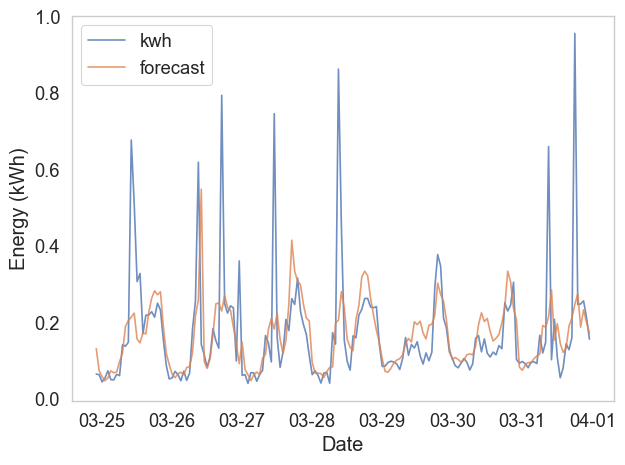

In [7]:
# Making the prediction on the validation set
# Only applicable if train_test_split in the conf.yml > 0
yhat = deep_learner.predict()

if len(yhat) > 0:

    # Constructing the forecast dataframe
    fc = d.tail(len(yhat)).copy()
    fc.reset_index(inplace=True)
    fc['forecast'] = yhat

    # Ploting the forecasts
    fig, ax1 = plt.subplots(figsize=(7, 5))
    for dtype in ['kwh', 'forecast']:
        ax1.plot(
            'Datetime',
            dtype,
            data=fc,
            label=dtype,
            alpha=0.8
        )
        
    ax1.set(xlabel="Date",
            ylabel="Energy (kWh)")
    
    # Define the date format
    date_form = DateFormatter("%m-%d")
    ax1.xaxis.set_major_formatter(date_form)
        
    plt.legend()
    plt.grid()
    
    plt.savefig(f"{c.loc_fig}/LSTM_predictions")
    
    plt.show() 

In [8]:
# Save predictions for further comparsions
fc.to_csv(f"{c.loc_out}/rnn_predictions.csv")

In [9]:
#Accuracy metrics for the forecast: forecast bias, mean absolute error, mean squared error, and root mean square error
expected = fc['kwh']
predictions = fc['forecast']
forecast_errors = [expected[i]-predictions[i] for i in range(len(expected))]
bias = sum(forecast_errors) * 1.0/len(expected)
mae = mean_absolute_error(expected, predictions)
mse = mean_squared_error(expected, predictions)
rmse = sqrt(mse)
#print('Forecast Errors: %s' % forecast_errors)
print('Bias: %f' % bias)
print('MAE: %f' % mae)
print('MSE: %f' % mse)
print('RMSE: %f' % rmse)

Bias: 0.004786
MAE: 0.067837
MSE: 0.017253
RMSE: 0.131352


In [10]:
# Forecasting n steps ahead   

# Creating the model using full data and forecasting n steps ahead
deep_learner = DeepModelTS(
    data=d, 
    Y_var='kwh',
    lag=24,
    LSTM_layer_depth=64,
    epochs=500,
    train_test_split=0 
)

# Fitting the model 
deep_learner.LSTModel()

# Forecasting n steps ahead
n_ahead = 168
yhat = deep_learner.predict_n_ahead(n_ahead)
yhat = [y[0][0] for y in yhat]

Epoch 1/500
7/7 [==============================] - 1s 13ms/step - loss: 0.0387 - acc: 0.0000e+00
Epoch 2/500
7/7 [==============================] - 0s 13ms/step - loss: 0.0230 - acc: 0.0000e+00
Epoch 3/500
7/7 [==============================] - 0s 13ms/step - loss: 0.0184 - acc: 0.0000e+00
Epoch 4/500
7/7 [==============================] - 0s 13ms/step - loss: 0.0178 - acc: 0.0000e+00
Epoch 5/500
7/7 [==============================] - 0s 13ms/step - loss: 0.0172 - acc: 0.0000e+00
Epoch 6/500
7/7 [==============================] - 0s 13ms/step - loss: 0.0173 - acc: 0.0000e+00
Epoch 7/500
7/7 [==============================] - 0s 13ms/step - loss: 0.0170 - acc: 0.0000e+00
Epoch 8/500
7/7 [==============================] - 0s 13ms/step - loss: 0.0170 - acc: 0.0000e+00
Epoch 9/500
7/7 [==============================] - 0s 12ms/step - loss: 0.0169 - acc: 0.0000e+00
Epoch 10/500
7/7 [==============================] - 0s 13ms/step - loss: 0.0168 - acc: 0.0000e+00
Epoch 11/500
7/7 [===========

In [11]:
# Constructing the forecast dataframe
fc = d.tail(100).copy()
fc = fc.reset_index() 
fc['type'] = 'original'

last_date = max(fc['Datetime'])
hat_frame = pd.DataFrame({
    'Datetime': [last_date + timedelta(hours=x + 1) for x in range(n_ahead)], 
    'kwh': yhat,
    'type': 'forecast'
})

fc = fc.append(hat_frame)
fc.reset_index(inplace=True, drop=True)

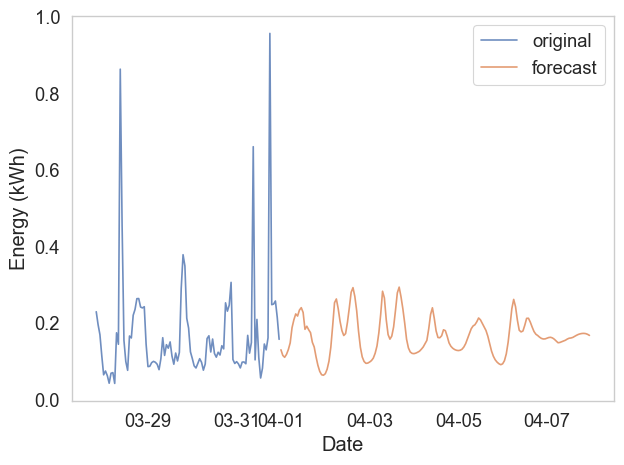

In [12]:
# Ploting the forecasts 
# Ploting the forecasts
fig, ax1 = plt.subplots(figsize=(7, 5))
for col_type in ['original', 'forecast']:
    ax1.plot(
        'Datetime', 
        'kwh', 
        data=fc[fc['type']==col_type],
        label=col_type,
        alpha=0.8,
        )
    
ax1.set(xlabel="Date",
        ylabel="Energy (kWh)")

plt.legend()
plt.grid()

# Define the date format
date_form = DateFormatter("%m-%d")
ax1.xaxis.set_major_formatter(date_form)

plt.savefig(f"{c.loc_fig}/LSTM_Forecast")   